# CEE 6200 Assignment 2
Understanding hydrologic processes is a key to water resources systems managment. This assignment will walk you through some foundational concepts of hydrology and hydrologic modeling.


In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from find_droughts import find_droughts
from scipy.stats import genextreme as gev
from Hymod_functions import hymod_main

## Part 1: Visualizing Hydrologic Data
### (1a)
Streamflow and precipitation data are usually plotted together as a combined hydrograph and hyetograph (from Greek hyetos, “rain”). Streamflow is plotted as a time series, while rainfall is shown as an inverted bar plot along the top of the graph. Streamflow labels are shown on the left y-axis, while rainfall labels are shown on the right y-axis.

Create a combined hydrograph/hyetograph for this one year of Leaf River data. It should look like this:

![](Hydro-hyetograph_sol.png)

As a first step, we'll load the data as a pandas data frame. Pandas is a helpful library for managing data in python: https://pandas.pydata.org/pandas-docs/stable/index.html. 

We'll the data using the function "read_csv", the data file is a csv file, so the "separator" is a ','. We'll then extract the first year of data using the "iloc" function (extract the first 365 days which correspond to rows 0 to 364).

In [2]:
# load the data
leaf_data = pd.read_csv('LeafCatch.csv', sep=',')

# extract the first year of data
leaf_data = leaf_data.iloc[0:364]

You can access a single column like this:

In [3]:
precip = leaf_data['Precip']

Let's print it to see what it looks like:

In [4]:
print(precip)

0      0.0
1      0.0
2      0.0
3      0.0
4      0.0
      ... 
359    0.0
360    0.0
361    0.0
362    1.6
363    0.0
Name: Precip, Length: 364, dtype: float64


Now we can plot, we'll set it up for you. Use the basic plot function to create the hydrograph (https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) and the bar function to create the hyetograph (https://matplotlib.org/api/_as_gen/matplotlib.pyplot.bar.html) **(5 points)**.

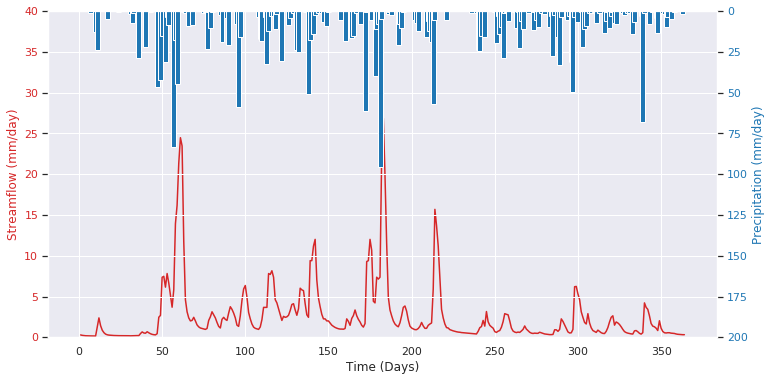

In [5]:
# first we'll make an axis for the hydrograph
fig, strmflw_ax = plt.subplots(figsize=[12,6])
strmflw_ax.set_ylim([0, 40])

# then we'll make a second y-axis for the hyetograph
precip_ax = strmflw_ax.twinx()
precip_ax.set_ylim([0, 200])
precip_ax.invert_yaxis()

# to plot streamflow use strmflow_ax.plot()
# to plot precip use precip_ax.bar()

############# add your code here ###################

strmflow = leaf_data['Strmflw']
t = list(range(1,len(strmflow)+1))
leaf_data.insert(0, "Time", t, True)
time = leaf_data['Time']

color = 'tab:red'
strmflw_ax.set_xlabel('Time (Days)')
strmflw_ax.set_ylabel('Streamflow (mm/day)', color=color)
strmflw_ax.plot(time, strmflow, color=color)
strmflw_ax.tick_params(axis='y', labelcolor=color)

color = 'tab:blue'
precip_ax.set_ylabel('Precipitation (mm/day)', color=color)
precip_ax.bar(time, precip,3, color=color)
precip_ax.tick_params(axis='y', labelcolor=color)

####################################################


### (1b)
Next, let's take a look at how the magnitude of streamflows vary. To visualize the variability of streamflow in a particular watershed, hydrologists often use a Flow Duration Curve. This is essentially a cumulative distribution function (CDF) that, for historical reasons, is flipped sideways. Here is an example of the flow duration curve that you’ll make:

![](flow_duration_curve.png)

Streamflow is shown on the y-axis using a log scale, to emphasize differences in extreme values. The x-axis shows the fraction of time that a given flow value is exceeded. For example, the highest recorded flow value is exceeded 0% of the time, while the smallest recorded flow value is exceeded 100% of the time (at least, as far as historical data can tell us). 
Reproduce this plot for the same Leaf River data we used in Problem 1a. There are functions in python to create empirical CDFs, but it’s fairly straightforward to do yourself. Think about it this way: you already have the streamflow data (y-axis), and if you sort the streamflow values in order, you know exactly what percentage of days are greater or less than each flow value. **(5 points)**.


To set the y-axis to log scale, use the matplotlib command 'semilogy': https://kite.com/python/docs/matplotlib.pyplot.semilogy

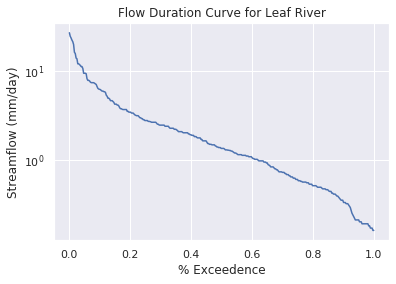

In [6]:
############# add your code here ###################
spacing_strm = np.linspace(0,1,364)
strmflw_sort = sorted(strmflow, reverse = True)
plt.semilogy()
plt.plot(spacing_strm, strmflw_sort)
plt.title('Flow Duration Curve for Leaf River')
plt.xlabel('% Exceedence')
plt.ylabel('Streamflow (mm/day)')
plt.show()

####################################################

## Part 2: Quantifying Extremes

Water resources analysts are often interested in the extremes of data sets (floods/droughts etc.); in Part 2, we will examine two metrics for quantifying extremes. To complete this part of the assignment download the you will need the Leaf River data set from Part 1 as well as the Falls-Lake-Log-Streamflows.csv data set and the findDroughts function. 

### (2a) 
Return periods are a commonly used metric for quantifying the frequency of extreme events. The return period (RP) can be thought of as the expected waiting time between extreme events. The return period of an event with magnitude x is defined as:

$$RP = \frac{1}{1-F(x)}$$

Where $F(x)$ is the cumulative distribution function of all events X. $1-F(x)$ is known as the exceedance probability. A ten year 24-hour rainfall event, for example, will have a rainfall depth that will only be exceeded on average once every ten years, and therefore its exceedance probability is: $1-0.90=0.10$

$$10 years = \frac{1}{1-0.90}$$

To solve for the magnitude of the 10-year storm, one would solve for x in equation 1 by finding the inverse of CDF of the corresponding return period. The magnitude of the 10-year 24-hour rainfall event from the Leaf Catchment data set can be calculated as follows:

$$10 years = \frac{1}{1-F(x)} \rightarrow F(x)=0.90 \rightarrow x = F(x)^{-1} = 126.59mm$$

Where $F(x)^{-1}$ is the inverse cdf of the GEV fit to the historical data set.

In this exercise, we will calculate the magnitude, x, of the 20, 50, 100, 200 and 500-year return period 24 hour rainfall events based of the most current 30 years of the Leaf Catchment historical data set.  In Matlab or your language of choice, use the following procedure to find the magnitude of each return period **(10 points)**:


1.	Reload the leaf river data and extract the most current 30 years of precipitation. You can assume all years have 365 days (i.e. ignore leap years). 
2.	Find the annual maximum value for each of the 30 years.
3.	Fit a GEV to the annual maximum data set. In python, use the command gev.fit(), we've already loaded this from the scipy library: https://docs.scipy.org/doc/scipy-0.15.1/reference/generated/scipy.stats.genextreme.html
4.	Calculate the magnitude of each return period. A helpful command to use is .ppf from the GEV distribution made above
5.	Summarize your findings in the markdown table below the code (just double click to edit)


In [ ]:
############# add your code here ###################
leaf_data = pd.read_csv('LeafCatch.csv', sep=',')
precip = leaf_data['Precip']
precip_30yrs = precip.iloc[(len(precip) - 30*365):len(precip)]


yrly_max = np.zeros(30)
pos = 0
for i in range(0,30):
    yrly_max[i] = max(precip_30yrs[pos:(pos+364)])
    pos += 365

RP = np.array([10, 20, 50, 100, 200, 500])
Fx = 1-(1/RP)
gev_fit = gev.fit(yrly_max)
values = gev.ppf(Fx,gev_fit[0],loc = gev_fit[1],scale = gev_fit[2])
print(values)


####################################################



---


*...Edit the table below-->(double click to edit)...*

| RP            | Magnitude (mm)                     |
| ------------- |:----------------------------------:|
| 10 year       | 126.59 (good sanity check)         |
| 20 years      | 147.47                             |
| 50 year       | 177.12                             |
| 100 year      | 201.44                             |
| 200 year      | 227.63                             |
| 500 year      | 265.42                             |

---

# (2b) 
Defining what constitutes a period of drought is a difficult question that has been a source of contention in the water resources community for decades. One method of defining drought is through a six month Standardized Streamflow Indicator (SSI6), also known as SRI, Standardized Runoff Indicator (Mckee et. al 1993). The SSI6 is a measure of the deviation from the historical mean of the 6 month moving average of a given streamflow record. Using this statistic, a drougth can be defined as a time interval where the SSI6 < 0 for at least 6 consecutive months and SSI6 < -1 for at least one week within that period (Herman et al 2016). In this exercise, we will use this criterion to search through a historical data set, identify periods of drought and visualize them over the historical record.  Streamflows in the data set of interest are known to follow a log-normal distribution. Log(streamflow) data has been uploaded to blackboard. 

To find the periods of historical drought, follow the procedure below **(5 points)**:


1.	Load the log-transformed streamflow data from the Falls-Lake-Log-Streamflows.csv file on blackboard. This file contains a time series of $Y_t=ln⁡(Q_t )$, where Qt is the observed inflows and Yt is the log-transformed stream flows.
2.	Normalize the weekly log(streamflow) by subtracting the mean of the entire record and dividing by the standard deviation:
$Z_t=(Y_t-μ ̂)/\hat{\sigma} ̂$
This value represents how many standard deviations away from the sample mean a given week’s inflow was.
3.	Calculate the SSI6, the 6-month moving average of Zt for each week. Save these values in a new pandas dataframe with a column named "ssi" (https://kite.com/python/answers/how-to-create-pandas-dataframe-from-a-numpy-array-in-python).
4.	Use the findDroughts function to search through the historical record and identify the periods of drought, defined as at least 6 months (24 consecutive weeks) where the SSI6 < 0 and for at least 1 week $SSI6 < -1$. Make sure to examine the function to until you understand how it works. The output of this function will be a new Pandas dataframe with three columns "start" containing the start week of the drought, "end" containing the end weeks of each drought and "severity" containing the minimum SSI6 value during the drought.  
5.	Plot the time series of log(inflows) and shade the regions that have been identified as droughts. The final plot should resemble the one shown below. 

!['example'](fallsLakeDroughts.png)

Hint: to make this plot, use the python function "axvspan" to shade the droughts, make sure to adjust the transparency using the alpha argument (https://matplotlib.org/gallery/subplots_axes_and_figures/axhspan_demo.html#sphx-glr-gallery-subplots-axes-and-figures-axhspan-demo-py)

In [8]:
# load the data (we're doing this for you because of the date format)
df = pd.read_csv('Falls-Lake-Log-Streamflows.csv', parse_dates=[0], index_col=0)

# calculate SSI6 (hint: Pandas function mean, std and rolling will be helpful)

############# add your code here ###################

df_norm = (df - df.mean()) / df.std()
df_roll = df_norm.rolling(24).mean()
df_roll.columns = ["ssi"]
droughts = find_droughts(df_roll)
droughtsdf = pd.DataFrame(droughts)
droughtsdf

####################################################


,start,end,severity
0,1932-07-31,1933-02-05,-16.539330
1,1933-07-30,1934-07-01,-37.163406
2,1941-09-14,1942-11-22,-25.532905
3,1943-09-05,1944-04-16,-23.226644
4,1954-08-15,1955-04-10,-22.751090
5,1966-08-28,1967-04-23,-20.832861
6,1968-06-30,1969-03-09,-24.340664
7,1970-07-19,1971-03-07,-21.265378
8,1978-09-03,1979-03-11,-17.216224
9,1980-08-31,1982-02-14,-44.930796


Add plotting code below 

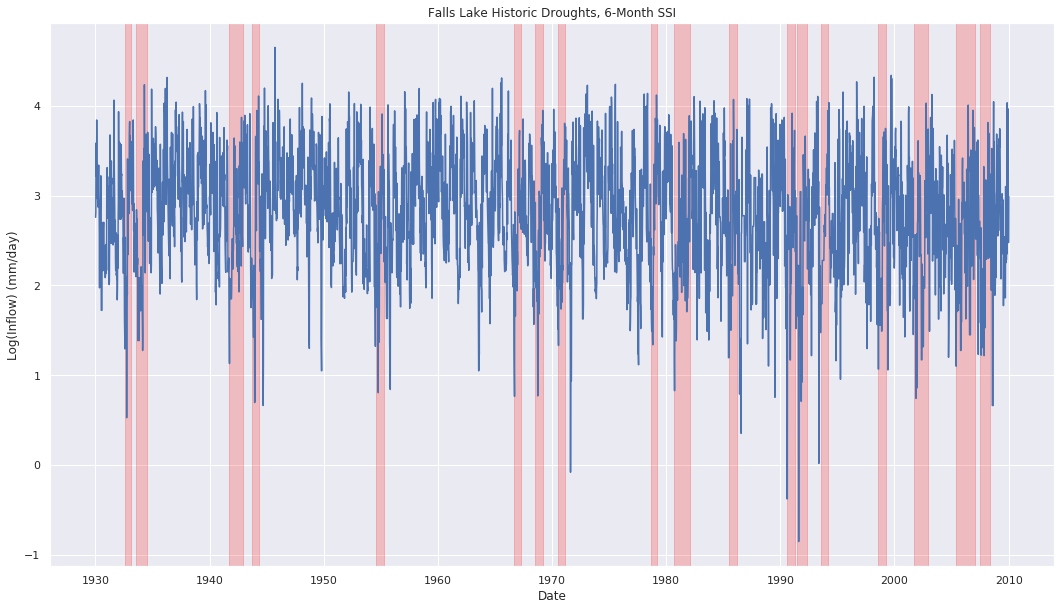

In [9]:
############# add your code here ###################

plt.figure(figsize = (18,10))
plt.plot(df)
for n in range(0,18):
    plt.axvspan(xmin=droughtsdf['start'][n], xmax=droughtsdf['end'][n],color = 'red', alpha = 0.2)
plt.xlabel('Date')
plt.ylabel('Log(Inflow) (mm/day)')
plt.title('Falls Lake Historic Droughts, 6-Month SSI')
plt.show()

####################################################

# Part 3: Rainfall-Runoff Modeling
The objective of Part 3 is to familiarize you with conceptual rainfall-runoff modeling, including explorations of parameter uncertainty and basic sensitivity analysis. This directory contains Python code for the HyMod rainfall-runoff model. Take some time to review both the model diagram below, and the code that makes it work in the Hymod_functions folder. Then answer the following questions:


![](hymod.png)

---

### Model Parameters
**Huz**: Maximum storage size

**b**:      Distribution of storage sizes between 0 and Huz

**Alp**:    Fraction of runoff contributing to quick flow 

**Kq**:     Quick flow residence time of linear infinite reservoir (the Kq values of all three linear reservoirs are the same)

**Ks**:Slow flow residence time of linear infinite reservoir

### Variables

**PP**:    Precipitation

**ET**:    Evapotranspiration

**OV**:    Runoff

**Qq**:    Quick Flow

**Qs**:    Slow Flow

**QQ**:    Streamflow (Quick Flow + Slow Flow)

**XHuz** and **XCuz**: Current moisture state of soil moisture accounting component (as depth XH or volume XC)

---

### (3a)
In the context of the diagram above, what does the Nash function do? Enter your answer in the cell below **(2 points)**.

...*Add markdown explanation here-->(double click to edit)...*

### (3b) 
In the context of the diagram above, what does the Pdm01 function do? **(2 points)**

...*Add markdown explanation here-->(double click to edit)...*

### (3c)
Use Hymod to perform single model runs, using the same Leaf River data as in Part 1. There are five parameters that must be chosen by the user: Kq, Ks, Alp, Huz, and B. Alter these parameters manually until you observe an acceptable match between the observed and simulated streamflow. (This can be done visually by plotting LeafCatch['Strmflw'].iloc[0:365] and Model['Q'] vs. time). Report the final parameter values you used. Provide the plot comparing the observed and simulated streamflows on a hydrograph (no need to include the hyetograph this time). Also provide a plot comparing the observed and simulated flow duration curves. How well do they match up? **(11 points)**

In [10]:
##### assign your parameters here #####

# Best fit params
Nq = 3   # number of quickflow routing tanks
Kq = 0.5    # quickflow routing tanks parameters 				- Range [0.1, 1]
Ks =  0.001   # slowflow routing tanks rate parameter 			- Range [0, 0.1]
Alp =  0.5  # Quick-slow split parameters 						- Range [0, 1]
Huz =  100  # Max height of soil moisture accounting tanks 	- Range [0, 500]
B =  1   # Distribution function shape parameter 				- Range [0, 2]

Run the Model in the following cell

In [11]:
Model = hymod_main.main(Nq, Kq, Ks, Alp, Huz, B, 'LeafCatch.csv')

Plot the results below, you'll likely have to do this several times

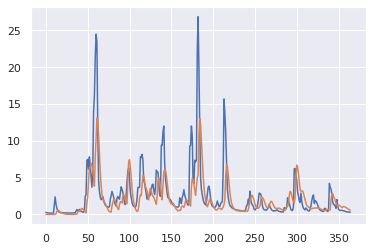

In [12]:
############# add your code here ###################

year_dat = leaf_data['Strmflw'].iloc[0:365]
precip_dat = leaf_data['Precip'].iloc[0:365]
plt.plot(year_dat)
plt.plot(Model['Q'])

####################################################

### (3d)
Create your own function(s) to compute two error metrics: the root-mean squared error (RMSE) and runoff coefficient error (ROCE, which describes the long-term average ratio of streamflow to precipitation). Use these to quantitatively compare the observed and simulated time series you found in Part 3c. How well does your “best” parameter set perform?  **(5 points)**

$$RMSE = \sqrt{\frac{1}{N}\sum_{t=1}{N}(Q_{sim,t}-Q_{obs,t})^2}$$

$$ROCE = \left\lvert\frac{\bar{Q}_{sim}-\bar{Q}_{obs}}{\bar{P}}\right\rvert$$

In [13]:
############# add your code here ###################

def RMSE (Q_sim, Q_obs):
    N = len(Q_sim)
    return np.sqrt(1/N * np.sum((Q_sim - Q_obs)**2))

def ROCE (Q_sim, Q_obs, P):
    return np.abs((Q_sim.mean() - Q_obs.mean()) / P.mean())

square_error = RMSE(Model['Q'],year_dat)
runoff_error = ROCE(Model['Q'], year_dat, precip_dat)

print("Square error is", square_error)
print("Runoff error is", runoff_error)

####################################################

Square error is 2.9817936228433775
Runoff error is 0.10500691915171004


...*Add markdown explanation here-->(double click to edit)...*

### (3e) 
Perform a Monte Carlo analysis of the feasible parameter space using uniform random sampling (assuming the model parameters are independent). The numpy library’s rand function can help you with this. For example, to create 20 samples of the parameter Kq, using its lower and upper bounds, you could do:

In [14]:

N = 1000 # number of samples

Nq = 3 #unspecificed and unclear if should vary.  Kept at 3 following diagram.

Kq_max = 1 # upper bound
Kq_min = 0.1 # lower bound
Kq_samples = (Kq_max-Kq_min)*np.random.rand(N)+Kq_min

Ks_max = 0.1 # upper bound
Ks_samples = (Ks_max)*np.random.rand(N)

Alp_max = 1 # upper bound
Alp_samples = (Alp_max)*np.random.rand(N)

Huz_max = 500 # upper bound
Huz_samples = (Huz_max)*np.random.rand(N)

B_max = 2 # upper bound
B_samples = (B_max)*np.random.rand(N)

#store model runs
runs = np.empty(365)
rmse_vec = np.zeros(N)
roce_vec = np.zeros(N)

for n in range(0,N):
    model = hymod_main.main(Nq, Kq_samples[n], Ks_samples[n], Alp_samples[n], Huz_samples[n], B_samples[n], 'LeafCatch.csv')
    rmse_vec[n] = RMSE(model['Q'],year_dat)
    roce_vec[n] = ROCE(model['Q'], year_dat, precip_dat)
    runs = np.vstack((runs, model['Q']))


Take all N parameter sets that you generate and run them through the model. The value of N is up to you, depending on your computing resources, but you should be able to run at least 1,000 evaluations without issue. Use the functions you wrote in (3d) to calculate the RMSE and ROCE values for each model evaluation. When these model runs are complete, please do the following:

i.	You can think of this uniform random sample as a crude form of optimization. Find the parameter set with the best RMSE value and report its parameters. Then, find the parameter set with the best ROCE value and report its parameters. Are these two parameter sets approximately the same? Why or why not? **(5 points)**

In [15]:
############# add your code here ###################

rlist = rmse_vec.tolist()
a = min(rlist)
i = rlist.index(a)
print('The param values for the min RMSE are Kq =', Kq_samples[i], 'Ks =', Ks_samples[i], 'Alp =', Alp_samples[i], 'Huz =', Huz_samples[i], 'B =', B_samples[i])

rolist = roce_vec.tolist()
b = min(roce_vec)
j = rolist.index(b)
print('The param values for the min ROCE are Kq =', Kq_samples[j], 'Ks =', Ks_samples[j], 'Alp =', Alp_samples[j], 'Huz =', Huz_samples[j], 'B =', B_samples[j])


####################################################

The param values for the min RMSE are Kq = 0.9608785332075291 Ks = 0.08883966539601684 Alp = 0.12678980636871828 Huz = 95.21267430956348 B = 0.6568173061060272
The param values for the min ROCE are Kq = 0.10091733572806037 Ks = 0.012521815129331116 Alp = 0.05862545324652124 Huz = 324.054746251299 B = 1.0970702514851687


...*Add markdown explanation here-->(double click to edit)...*

ii.	Create scatter plots of each parameter vs. the RMSE and ROCE metrics. Since you have 5 parameters and 2 error metrics, you should have 10 total plots (or subplots). Please put the error metric on the y-axis, and the parameter value on the x-axis. Which parameters appear to be most responsible for changes in the RMSE value? What about the ROCE value? How do you know? This is a simple form of sensitivity analysis, a topic we’ll return to later in the class. **(5 points)**

Text(0.5, 1.0, 'B vs. ROCE')

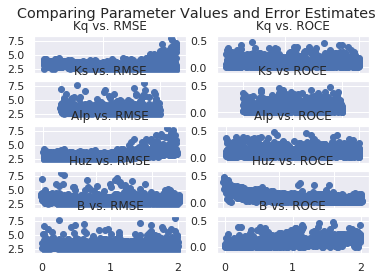

In [16]:
############# add your code here ###################

params = np.vstack((Kq_samples, Ks_samples))
params = np.vstack((params, Alp_samples))
params = np.vstack((params, Huz_samples))
params = np.vstack((params, B_samples))
params.transpose()

fig, axs = plt.subplots(5,2)
for r in range(0,5):
    axs[r,0].scatter(params[r,:],rmse_vec)
    axs[r,1].scatter(params[r,:],roce_vec)

fig.suptitle('Comparing Parameter Values and Error Estimates')
    
axs[0,0].set_title('Kq vs. RMSE')
axs[0,1].set_title('Kq vs. ROCE')
axs[1,0].set_title('Ks vs. RMSE')
axs[1,1].set_title('Ks vs ROCE')
axs[2,0].set_title('Alp vs. RMSE')
axs[2,1].set_title('Alp vs. ROCE')
axs[3,0].set_title('Huz vs. RMSE')
axs[3,1].set_title('Huz vs. ROCE')
axs[4,0].set_title('B vs. RMSE')
axs[4,1].set_title('B vs. ROCE')

####################################################

...*Add markdown explanation here-->(double click to edit)...*